In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

OBSI DATA

In [95]:
#Transform OBSI into column form, basic dataframe
OBSI = pd.read_excel("Data Summary QP Re-Analysis.xlsx", sheet_name = "ALL OBSI", header = 1).T
OBSI.rename_axis(None,axis=1, inplace = True)
OBSI.drop([0,4], axis = 1, inplace = True)
OBSI.columns = OBSI.iloc[0]
OBSI = OBSI[1:]
OBSI.reset_index(inplace = True)
OBSI.drop(["index"], axis = 1, inplace = True)
OBSI.columns.name = None
#Adds pavement type into dataframe
#Turn values into a lists if you want to add other metadata
pavement_type = {
    1: "3/8in Chip Seal",
    2: "1/4in Chip Seal",
    3: "Type II Microsurfacing",
    4: "Type III Microsurfacing",
    5: "3/8in Chip Seal",
    6: "Type III Microsurfacing",
    7: "Type II Microsurfacing",
    8: "1/4in Chip Seal"
}
OBSI["Pavement Type"]=[pavement_type[s] for s in OBSI["Site"]]

   Measurement Year Site Replicates      250      315      400      500  \
0                 0    1          1   78.273  79.7431  83.4532  86.1897   
1                 0    1          2  77.4241  79.9272  83.8309  86.5486   
2                 0    1          3  77.5036  79.7277  83.8058   86.526   
3                 0    1          4  77.5944  79.0367  83.2485  85.8418   
4                 0    2          1  78.1344  80.1366  84.0502   86.716   
5                 0    2          2  78.8716   80.655  84.7763  87.3138   
6                 0    2          3  77.9504  80.1493  83.9644  86.7228   
7                 0    2          4  78.4028  80.5329  84.7246  87.2242   
8                 0    3          1  75.0476  76.9979  81.2193   84.162   
9                 0    3          2  75.1637  76.7856  81.3386  84.3535   
10                0    3          3   76.544   77.456  81.7617  84.7726   
11                0    4          1  81.1325  83.3398  87.3188  89.3846   
12                0    4 

ALL PASSBY DATA

In [214]:
allpassby = pd.read_excel("Data Summary QP Re-Analysis.xlsx", sheet_name="All Passby", header=[0,1])
allpassby.dropna(axis = 0, how = "all",inplace = True)
allpassby.dropna(axis = 1, how = "all", inplace = True)


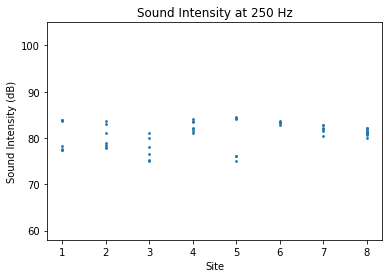

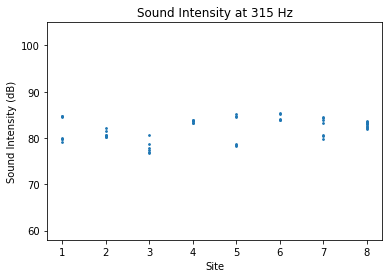

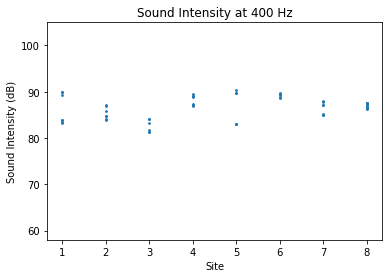

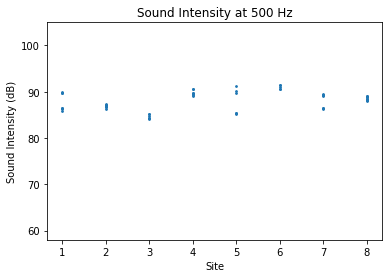

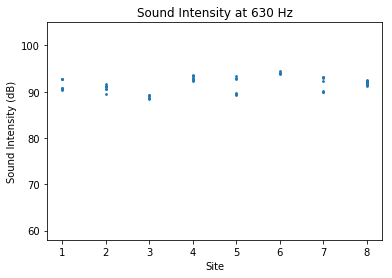

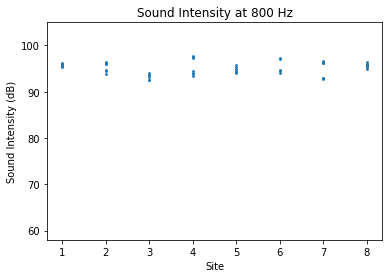

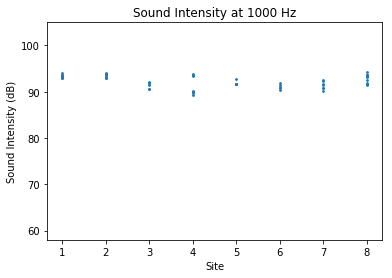

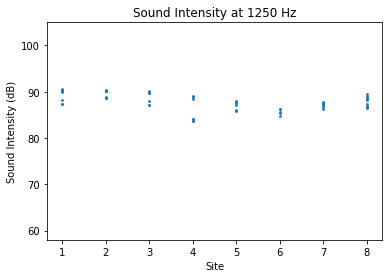

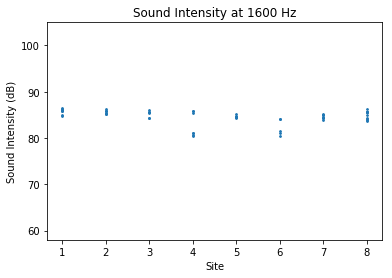

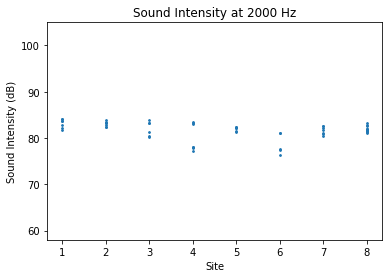

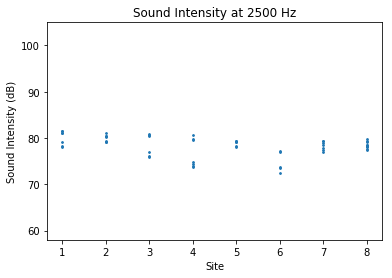

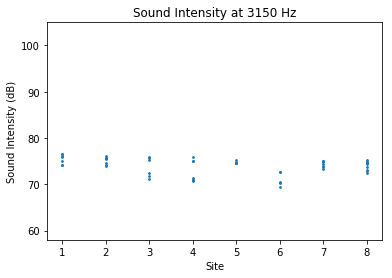

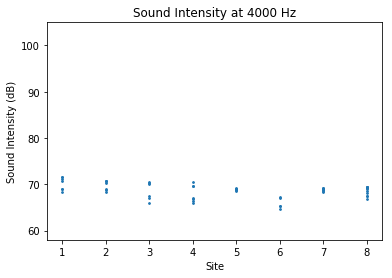

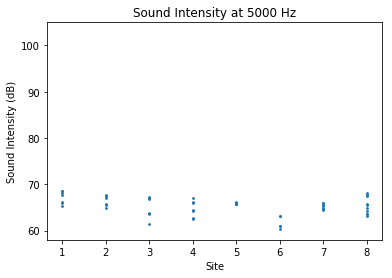

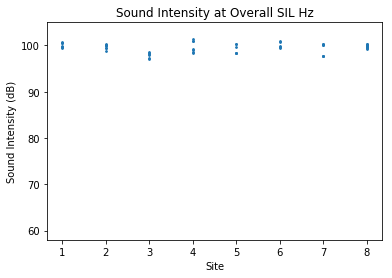

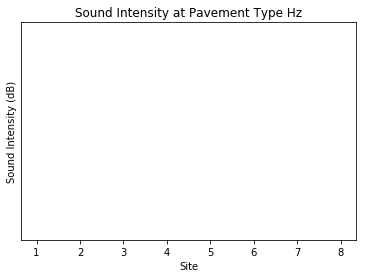

In [192]:
#Plot data by site and sound intensity. Each figure is a different frequency
for freq in OBSI.columns[3:]:
    plt.figure()
    plt.scatter(OBSI["Site"],OBSI[freq], s = 3)
    plt.title("Sound Intensity at " + str(freq) + " Hz")
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
#     plt.ylim(58,105)

In [203]:
#Group data by year, site, pavement type, and replicates
OBSI_grouped = OBSI.set_index(["Measurement Year", "Site", "Pavement Type","Replicates"])
OBSI_grouped= OBSI_grouped.swaplevel("Pavement Type", "Site") #Use this to swap levels
OBSI_grouped.sort_index(inplace=True)
OBSI_grouped = OBSI_grouped.astype(float)

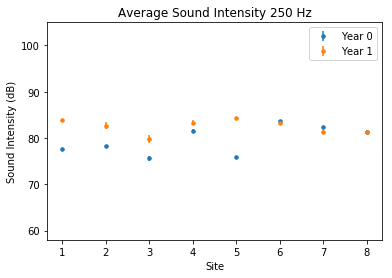

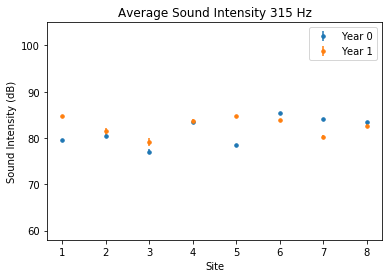

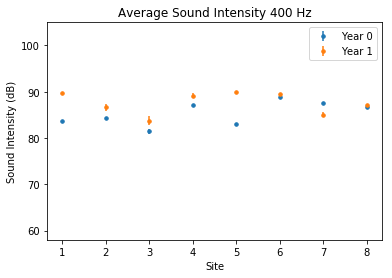

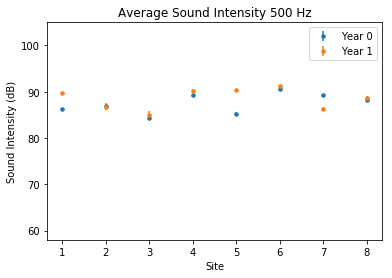

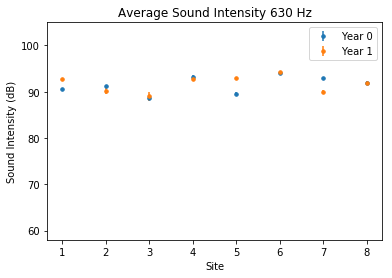

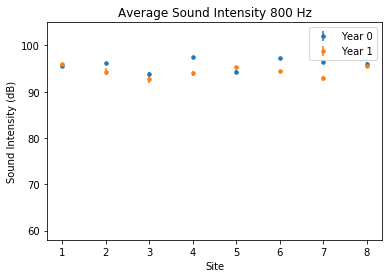

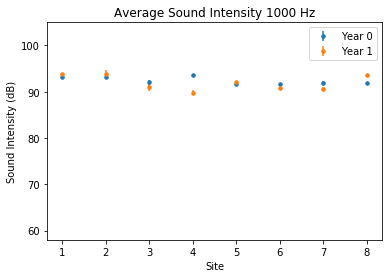

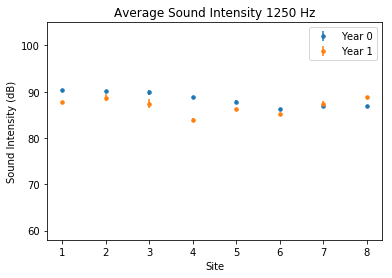

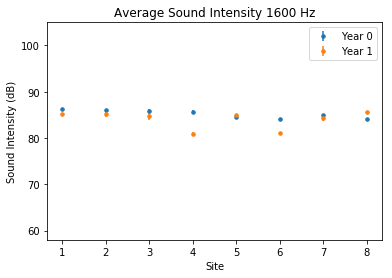

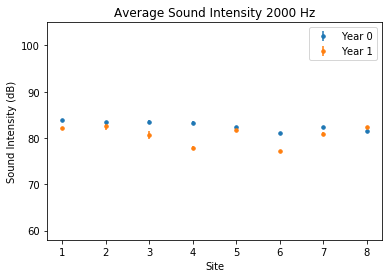

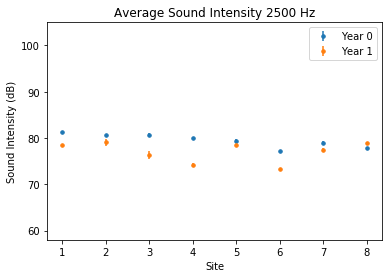

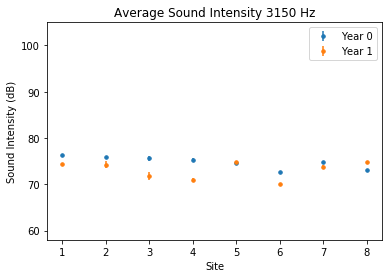

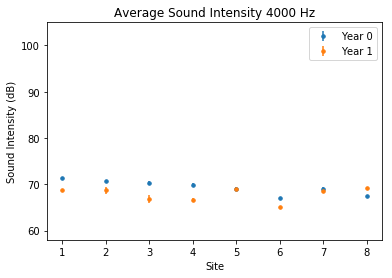

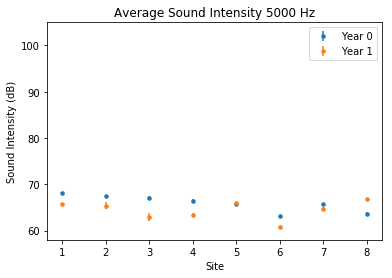

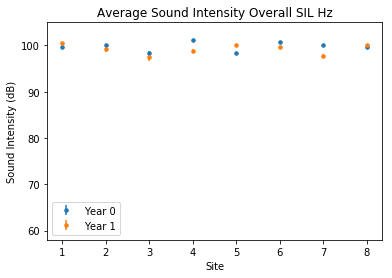

In [199]:
#Mean grouped by year and site
OBSI_mean_by_site = OBSI_grouped.groupby(level = [0,1]).mean()
OBSI_yearly_sem = OBSI_grouped.groupby(level = [0,1]).sem()
#Plot data by site and sound intensity averaged and separated by year
for freq in OBSI_mean_by_site.columns:
    plt.figure()
    plt.errorbar(OBSI_mean_by_site.loc[0].index,OBSI_mean_by_site.loc[0][freq], 
                OBSI_yearly_sem.loc[0][250], ls = "None",marker = ".", ms= 7, label = "Year 0")
    plt.errorbar(OBSI_mean_by_site.loc[1].index,OBSI_mean_by_site.loc[1][freq],
                OBSI_yearly_sem.loc[1][250], ls = "None",marker = ".", ms = 7, label = "Year 1")
    plt.legend()
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
    plt.ylim(58,105)
    plt.title("Average Sound Intensity "+ str(freq) + " Hz")

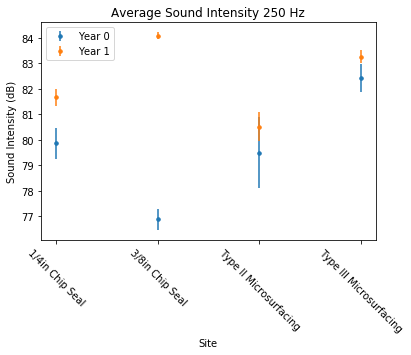

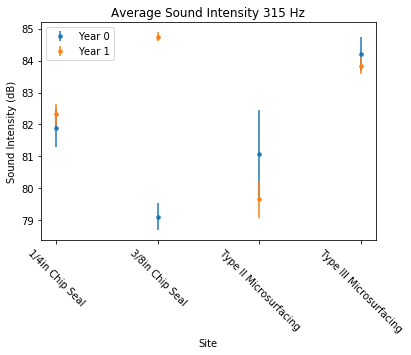

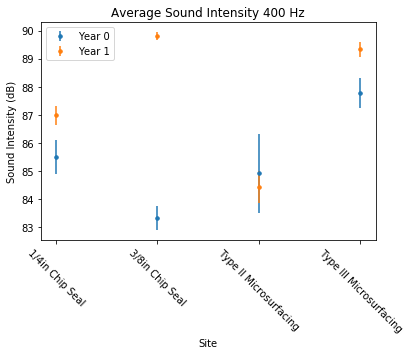

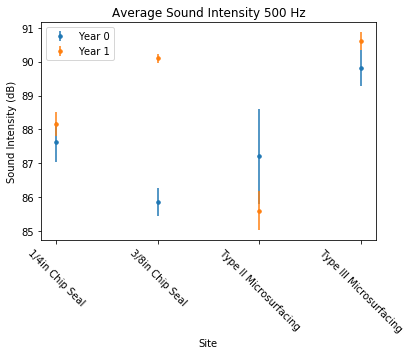

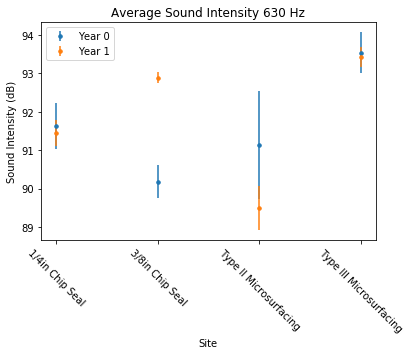

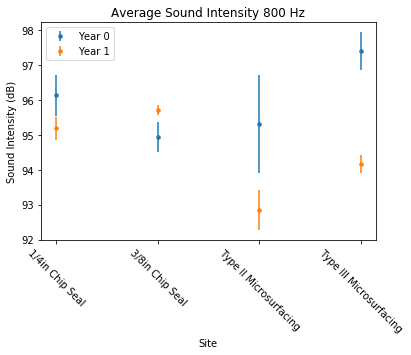

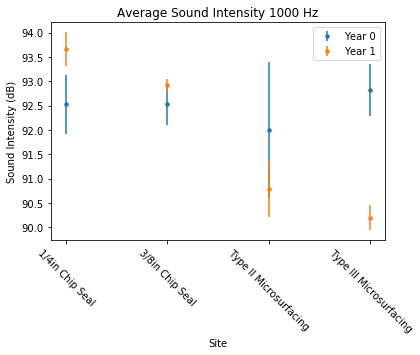

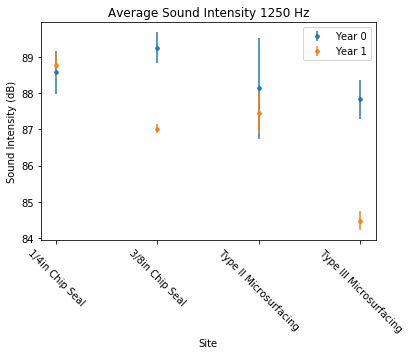

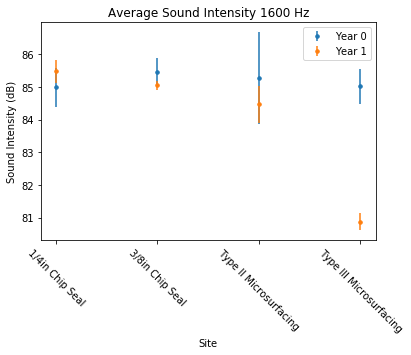

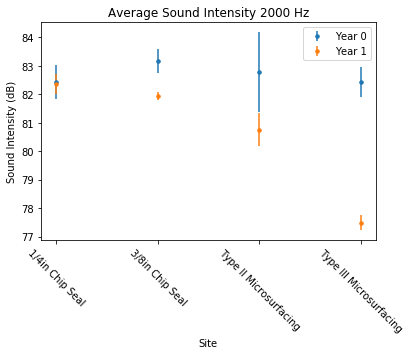

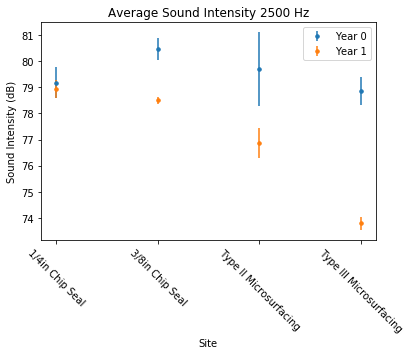

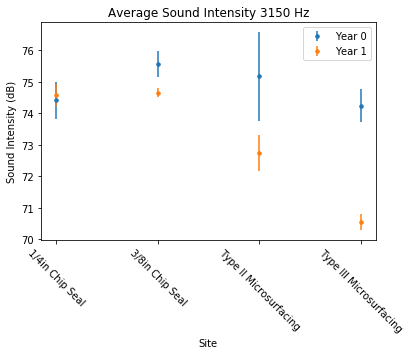

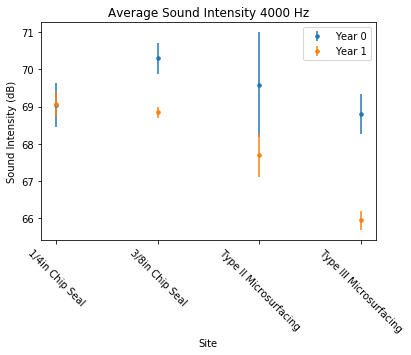

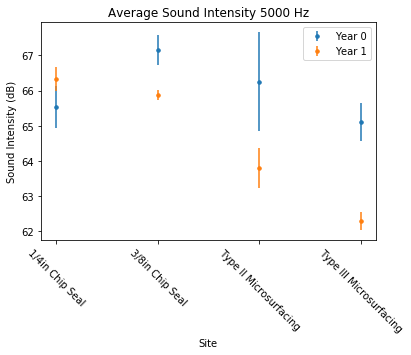

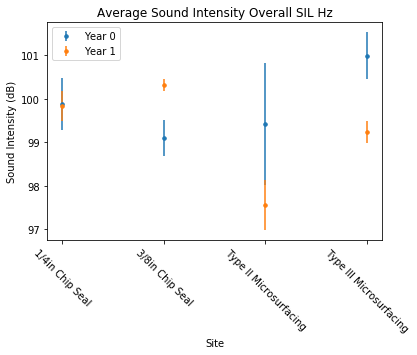

In [197]:
#Mean grouped by year and pavement type
OBSI_mean_by_pavement = OBSI_grouped.groupby(level = [0,2]).mean()
OBSI_sem_by_pavement = OBSI_grouped.groupby(level = [0,2]).sem()

for freq in OBSI_mean_by_pavement.columns:
    plt.figure()
    plt.errorbar(OBSI_mean_by_pavement.loc[0].index,OBSI_mean_by_pavement.loc[0][freq], 
                OBSI_sem_by_pavement.loc[0][250], ls = "None",marker = ".", ms= 7, label = "Year 0")
    plt.errorbar(OBSI_mean_by_pavement.loc[1].index,OBSI_mean_by_pavement.loc[1][freq],
                OBSI_sem_by_pavement.loc[1][250], ls = "None",marker = ".", ms = 7, label = "Year 1")
    plt.legend()
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
    plt.xticks(rotation=-45)
#     plt.ylim(58,105)
    plt.title("Average Sound Intensity "+ str(freq) + " Hz")

In [184]:
#Count how many datapoints are in each grouping
OBSI_counts_by_site =OBSI_grouped.groupby(level = [0,1]).count()
OBSI_counts_by_pavement =OBSI_grouped.groupby(level = [0,2]).count()
OBSI_counts_by_pavement

250  315  400  500  630  800  1000  \
Measurement Year Pavement Type                                                 
0                1/4in Chip Seal            8    8    8    8    8    8     8   
                 3/8in Chip Seal            7    7    7    7    7    7     7   
                 Type II Microsurfacing     7    7    7    7    7    7     7   
                 Type III Microsurfacing    5    5    5    5    5    5     5   
1                1/4in Chip Seal           10   10   10   10   10   10    10   
                 3/8in Chip Seal            6    6    6    6    6    6     6   
                 Type II Microsurfacing     6    6    6    6    6    6     6   
                 Type III Microsurfacing    7    7    7    7    7    7     7   

                                          1250  1600  2000  2500  3150  4000  \
Measurement Year Pavement Type                                                 
0                1/4in Chip Seal             8     8     8     8     8     8   
                 3/8in Chip Seal             7     7     7     7     7     7   
                 Type II Microsurfacing      7     7     7     7     7     7   
                 Type III Microsurfacing     5     5     5     5     5     5   
1                1/4in Chip Seal            10    10    10    10    10    10   
                 3/8in Chip Seal             6     6     6     6     6     6   
                 Type II Microsurfacing      6     6     6     6     6     6   
                 Type III Microsurfacing     7     7     7     7     7     7   

                                          5000  Overall SIL  
Measurement Year Pavement Type                               
0                1/4in Chip Seal             8            8  
                 3/8in Chip Seal             7            7  
                 Type II Microsurfacing      7            7  
                 Type III Microsurfacing     5            5  
1                1/4in Chip Seal            10           10  
                 3/8in Chip Seal             6            6  
                 Type II Microsurfacing      6            6  
                 Type III Microsurfacing     7            7

In [178]:
OBSIbySite = OBSI.T
OBSIbySite.columns = ["S"+str(s)+"Y"+str(y)+"R"+str(r) for y,s,r in zip(OBSI["Measurement Year"],OBSI["Site"],OBSI["Replicates"])]
OBSIbySite = OBSIbySite[3:]
print(OBSIbySite)

                        S1Y0R1           S1Y0R2           S1Y0R3  \
250                     78.273          77.4241          77.5036   
315                    79.7431          79.9272          79.7277   
400                    83.4532          83.8309          83.8058   
500                    86.1897          86.5486           86.526   
630                    90.6283            90.74          90.9047   
800                    95.5003          95.4736          95.6579   
1000                   93.2674          93.0764          93.3365   
1250                   90.4746          90.2028          90.6352   
1600                   86.2794          86.1164          86.5537   
2000                   84.0429          83.6641          84.1068   
2500                   81.4986          81.1034          81.5768   
3150                   76.4767          76.1255          76.5212   
4000                   71.5557          71.2262          71.5751   
5000                   68.5469          68.0497 